In [1]:
#import metmhn.simulations as simul
import metmhn.Utilityfunctions as utils
import pandas as pd
import numpy as np

import jax as jax
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['text.usetex'] = True

In [5]:
import metmhn.jx.kronvec as kv
import jax.numpy as jnp

theta = jnp.log(jnp.array([[1.,2.,3.], [3.,4.,5.], [6.,7.,8.]]))
pt_diag = jnp.log(jnp.array([1.5, 2., 3.]))
mt_diag = jnp.log(jnp.array([3., 4., 5.]))
state = jnp.array([1,1,1,1,1])
p = jnp.ones(2**state.sum())
kv.diag_scal_p(pt_diag, state, p)
kv.kronvec_met(theta, p, 0, state)
kv.kronvec(theta, p, state)
kv.kron_diag(theta, state, int(state.sum()))
obs_inds = kv.obs_states(int(state.sum()), state, False)
utils.trunk_states(state)[jnp.where(obs_inds),:]


array([[[0, 1, 0, 1, 1],
        [1, 1, 0, 1, 1],
        [0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]]], dtype=uint8)

Read in a saved metMHN:

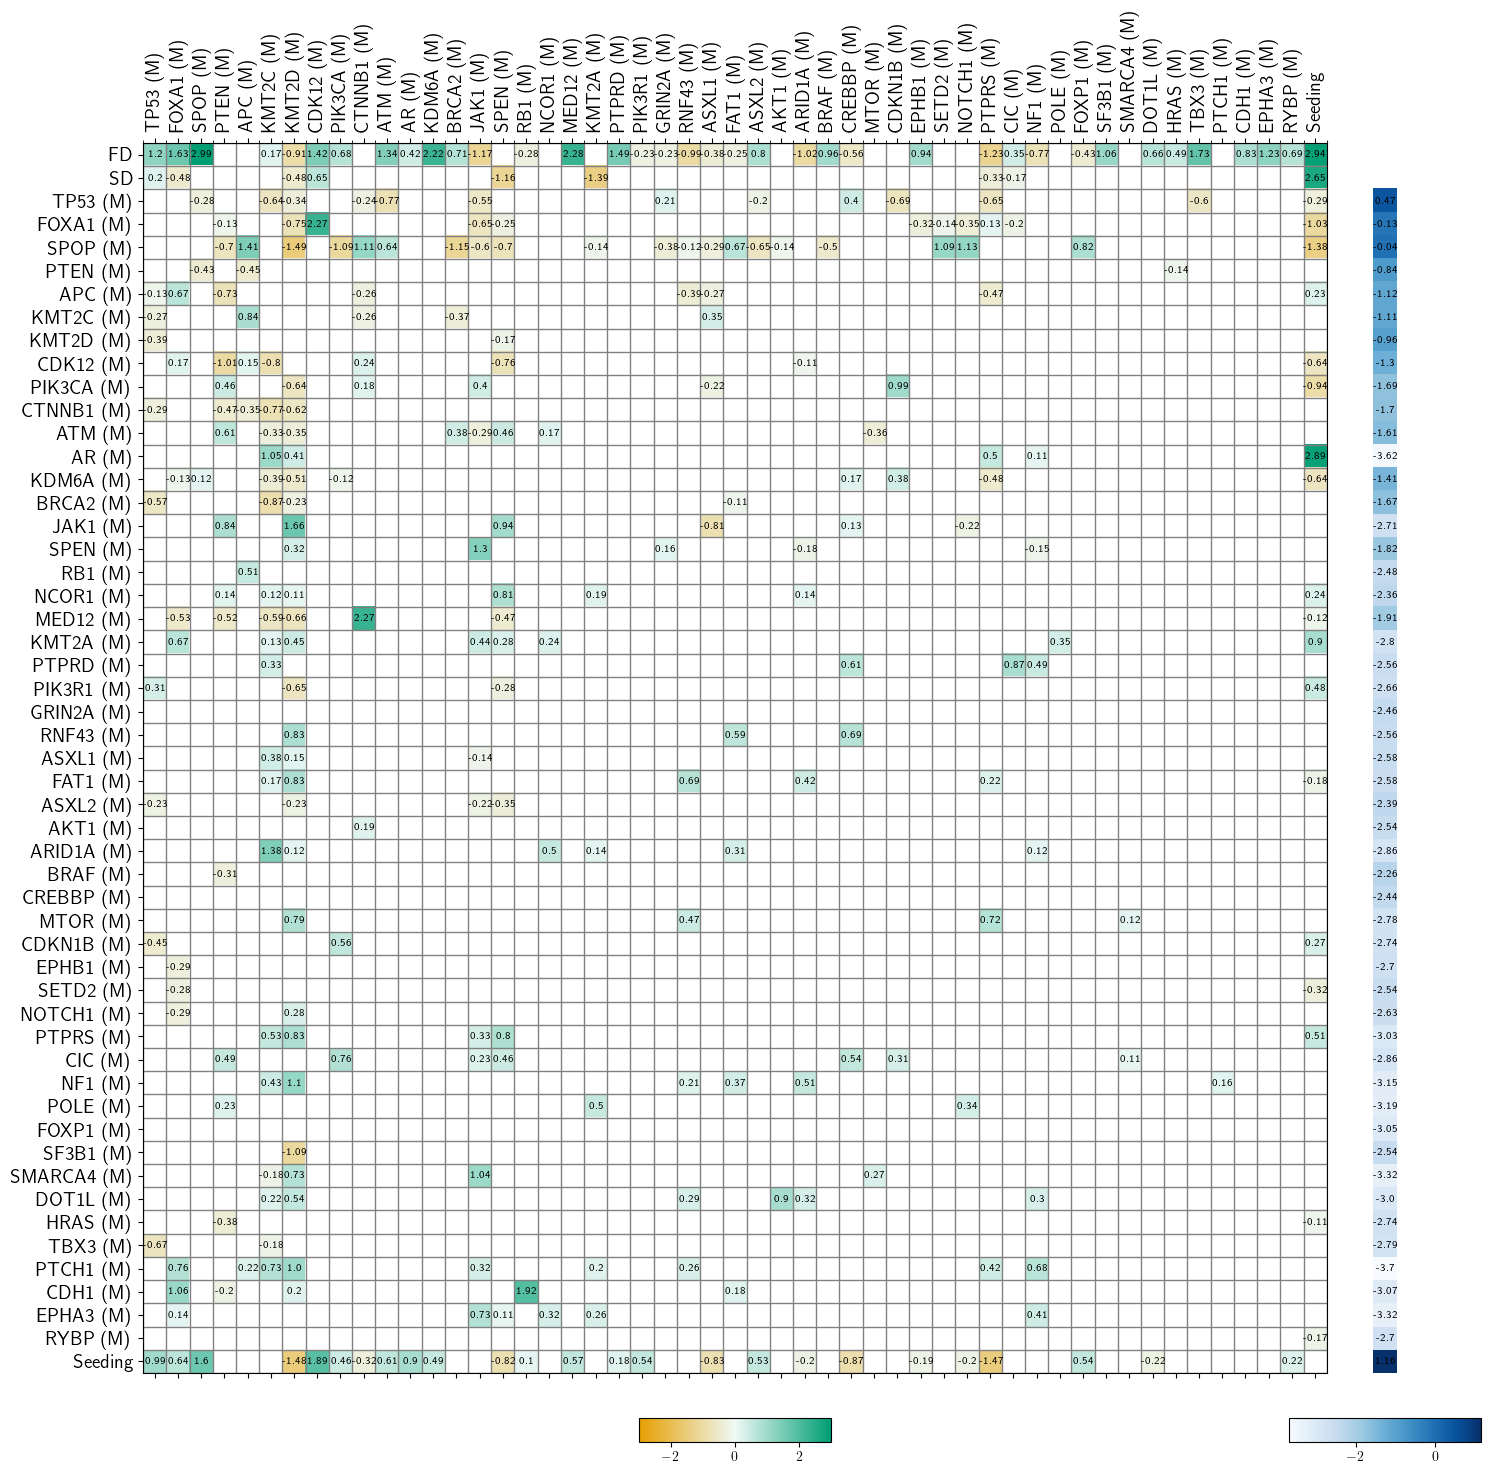

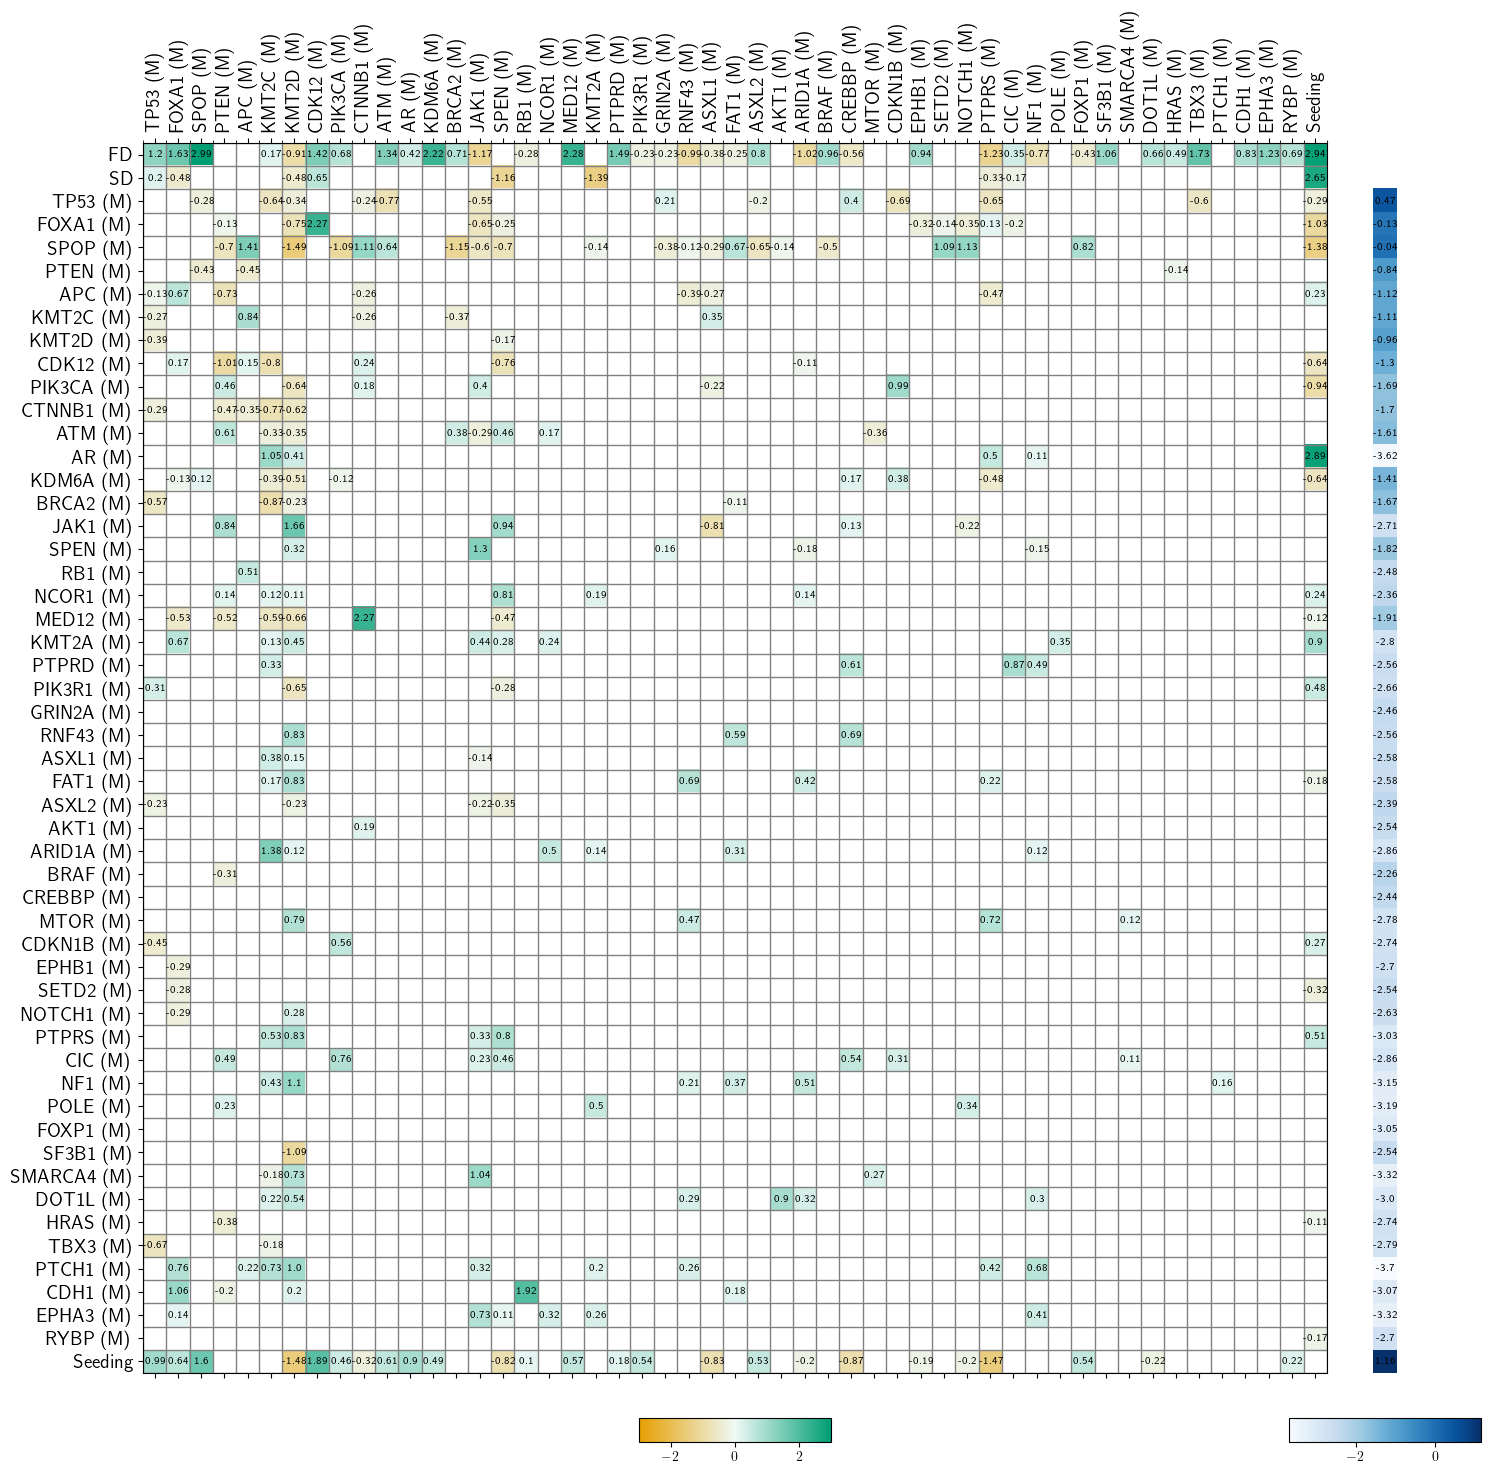

In [4]:
params = pd.read_csv("../results/prad/prad_50_muts_001.csv", index_col=0)
fd_effects = params.iloc[0,:].to_numpy()
sd_effects = params.iloc[1, :].to_numpy()
th_learned = params.iloc[2:,:].to_numpy()
events = params.columns
n = th_learned.shape[1]
rng = np.random.default_rng(seed=42)
utils.plot_theta(params.to_numpy(), events, 0.1, True, 7.5)

Calculate $P(t_{mut} < t_{seed}| x[mut] = 1)$ i.e. the probability that a mutation happend prior to the seeding for both primary tumors and metastases:

In [ ]:
mut_ps, mut_total_prim, mut_total_met = simul.p_any_mut_pre_seed(th_learned, fd_effects, sd_effects, 50000, rng)

In [ ]:
psp = pd.DataFrame(np.column_stack((mut_ps/mut_total_prim, mut_ps/mut_total_met)), 
                  index=events[:-1], columns=["PT", "MT"])
psp.sort_values(by=["MT"], inplace=True)
fig, ax = plt.subplots(figsize=(8.27, 11.69))

plt.style.use("default")
ax.set_xlim(0,1)
ax.axvline(0.5, color = "#D55E00", linestyle="dashed")
psp["MT"].plot(kind="barh", ax=ax, color="#D55E00")
ax.legend()

In [ ]:
dat, ps = simul.simulate_dat(th_learned, fd_effects, sd_effects, 10000, rng)


In [ ]:
dat_prim_nomet = dat[dat[:,-1]==0,:]
dat_coupled = dat[dat[:,-1]==1,:]
dat_coupled.shape[0]/10000

In [ ]:
n_mut = (dat_prim_nomet.shape[1]-1)//2
n_tot = n_mut + 1
arr = dat_coupled * np.array([1,2]*n_mut+[1])
arr = arr @ (np.diag([1,0]*n_mut+[1]) + np.diag([1,0]*n_mut, -1))
counts = np.zeros((4, n_tot))
for i in range(0,2*n_tot,2):
    i_h = int(i/2)
    for j in range(1,4):
        counts[j-1, i_h] = np.count_nonzero(arr[:,i]==j)/dat_coupled.shape[0]
    counts[3, i_h] = np.sum(dat_prim_nomet[:, i], axis=0)/dat_prim_nomet.shape[0]

labels = [["Coupled ("+str(dat_coupled.shape[0])+")"]*3 +\
        ["NM ("+str(dat_prim_nomet.shape[0])+")"],
        ["PT-Private", "MT-Private", "Shared"] + ["Present"]*3]
       
inds =  pd.MultiIndex.from_tuples(list(zip(*labels)))
counts = pd.DataFrame(np.around(counts, 2), columns=events, index=inds).T
counts

In [ ]:
import numpy as np
Q = np.array([[-40, 0., 0.], [20, -20, 0.], [20, 20, 0]])
diag = np.array([1e-200, 4, 10])
scal = np.diag(diag)
iwas = scal - Q
vec = np.array([1., 0., 0.])
print(scal @ np.linalg.solve(iwas, vec))

scal_inv = np.diag(1/diag)
iwas2 = np.diag([1., 1., 1.]) - Q @ scal_inv 
np.linalg.solve(iwas2, vec)

Calculate $P(t_{mut} < t_{seed} | x[mut] = z[mut] = 1)$ ie. the probability that a **shared** mutation between the primary tumor and the metastasis happened prior to the seeding

In [ ]:
mut_ps, mut_total = simul.p_shared_mut_pre_seed(th_learned, fd_effects, sd_effects, 10000, rng)
psp = pd.DataFrame(mut_ps/mut_total, index=events[:-1], columns=["Shared"])
psp.sort_values(by=["Shared"], inplace=True)
fig, ax = plt.subplots(figsize=(8.27, 11.69))
plt.style.use("default")
ax.set_xlim(0,1)
ax.axvline(0.5, color = "#D55E00", linestyle="dashed")
psp["Shared"].plot(kind="barh", color="#56B4E9", ax=ax)
ax.legend()